# Surface Diffusion Boundary

The simulation script described in this chapter is available at  [STEPS_Example repository](https://github.com/CNS-OIST/STEPS_Example/blob/master/user_manual/source/surface_diffusion_boundary.ipynb).

Just as it is sometimes useful to isolate some chemical species within certain volume compartments and allow others to diffuse to
neighbouring compartments, as described in [Diffusion Boundary](diffusion_boundary.ipynb), it is also sometime useful to allow some chemical species to diffuse between
neighbouring surface “Patches” whilst others remain isolated within one Patch. Analogously to diffusion boundaries between neighbouring compartments,
“Surface diffusion boundaries” allow surface diffusion between different patches that are connected through at least one pair of neighbouring
triangles in a mesh-based simulation.

Since many components of this surface diffusion boundary example script have already been introduced in previous chapters and the model is based on the surface diffusion model of of [Surface Diffusion](surface_diffusion.ipynb), this chapter will be fairly brief, focusing only on the new concepts related
solely to surface diffusion boundaries.

Solvers [steps.solver.Tetexact](API_solver.rst#steps.solver.Tetexact) and [steps.mpi.solver.TetOpSplit](API_mpi.rst#steps.mpi.solver.TetOpSplit) currently support Surface Diffusion Boundaries,
but this chapter will only show an example with the Tetexact solver. Since the solvers share an API, use is functionally equivalent in TetOpSplit.


## Modelling solution

### Organisation of code

As for previous models we will create a Python script to run the surface diffusion model.

As usual, at first we import STEPS modules and other modules `pylab` and `math`:


In [1]:
import steps.model as smodel
import steps.geom as stetmesh
import steps.utilities.meshio as smeshio
import steps.rng as srng
import steps.solver as solvmod
import pylab
import math

We set some simulation constants:


In [2]:
# Number of iterations; plotting dt; sim endtime:
NITER = 10

# The data collection time increment (s)
DT = 1.0

# The simulation endtime (s)
INT = 21.0

# Number of molecules injected in centre
NINJECT = 1000

# The diffusion constant for our diffusing species (m^2/s)
DCST = 0.08e-12

### Model specification

We create the biochemical model, equivalent to the surface diffusion model in [Surface Diffusion](surface_diffusion.ipynb) where we create
one species `X` and one surface diffusion rule:


In [3]:
def gen_model():
    mdl = smodel.Model()
    X = smodel.Spec('X', mdl)
    ssys = smodel.Surfsys('ssys', mdl)
    diff_X = smodel.Diff('diffX', ssys, X,  DCST)
    return mdl

### Geometry specification

The geometry for the simulation is the same flat disk-shaped tetrahedral mesh of radius 10 microns as in
the [Surface Diffusion](surface_diffusion.ipynb) example. This time, however, the circular surface will be separated into two Patches on the x=0 axis
which will be connected by a Surface Diffusion Boundary, as we will see later.

![The mesh used for the surface diffusion boundary simulation, showing the 2 separate patches](images/coin_sdb.png)

This is the disk-shaped mesh of radius 10 microns used for the simulation in this chapter. The region in red is ’Patch A’ and blue is ‘Patch B’. We will create a Surface Diffusion Boundary to connect these two Patches. 

The first step is to import the tetrahedral mesh.

In [4]:
mesh = smeshio.loadMesh('meshes/coin_10r_1h_13861')[0]

Then we create a compartment comprising all mesh tetrahedrons:


In [5]:
ntets = mesh.countTets()
comp = stetmesh.TmComp('cyto', mesh, range(ntets))

We go on to creating the surface [steps.geom.TmPatch](API_geom.rst#steps.geom.TmPatch) objects for this mesh-based simulation,
but, differently from the [Surface Diffusion](surface_diffusion.ipynb) example, we separate the surface into two Patches. The centre of the
mesh is at the origin (x=0, y=0, z=0) and so to split evenly in this simple example one Patch is comprised of triangles with +ve x barycentre
and the other with -ve x barycentres.

In order to create a Surface Diffusion Boundary we need to find information about the triangle ‘bars’ here. In STEPS, the
edges created by joining two vertices of any triangle are termed ‘bars’, and we can use
function [steps.geom.Tetmesh.getTriBars](API_geom.rst#steps.geom.Tetmesh.getTriBars) to get that information. In fact in this example we already
have the vertex information so the call to [steps.geom.Tetmesh.getTriBars](API_geom.rst#steps.geom.Tetmesh.getTriBars) is not strictly necessary, but we demonstrate its use here:


In [6]:
alltris = mesh.getSurfTris()

# Sort patch triangles as those of positive z: A +ve x, B -ve x
patchA_tris = []
patchB_tris = []
patchA_bars = set()
patchB_bars = set()

for t in alltris:
    vert0, vert1, vert2 = mesh.getTri(t)
    if (mesh.getVertex(vert0)[2] > 0.0 \
        and mesh.getVertex(vert1)[2] > 0.0 \
        and mesh.getVertex(vert2)[2] > 0.0):
        if mesh.getTriBarycenter(t)[0] > 0.0:
            patchA_tris.append(t)
            bar = mesh.getTriBars(t)
            patchA_bars.add(bar[0])
            patchA_bars.add(bar[1])
            patchA_bars.add(bar[2])
        else:
            patchB_tris.append(t)
            bar = mesh.getTriBars(t)
            patchB_bars.add(bar[0])
            patchB_bars.add(bar[1])
            patchB_bars.add(bar[2])

We create the two [steps.geom.TmPatch](API_geom.rst#steps.geom.TmPatch) objects. We call the Patch with +ve x (red in the figure above) `'PatchA'`
and the Patch with -ve x (blue in in the figure above) `'PatchB'`. Both share the same inner compartment we created earlier:


In [7]:
# Create the patch
patchA = stetmesh.TmPatch('patchA', mesh, patchA_tris, icomp=comp)
patchA.addSurfsys('ssys')
patchB = stetmesh.TmPatch('patchB', mesh, patchB_tris, icomp=comp)
patchB.addSurfsys('ssys')

Now we can create the [steps.geom.SDiffBoundary](API_geom.rst#steps.geom.SDiffBoundary) object. Analogously to the Diffusion Boundary between Compartments
which is made up of connecting triangles between those compartments, the Surface Diffusion Boundary is comprised
of a collection of ‘bars’ that connect two distinct Patches. The first thing, then, is to find that set of bars as the
intersection between all bars from `PatchA` and `PatchB`:


In [8]:
# Find the set of bars that connect the two patches as the intersecting bars of PatchA and PatchB
barsDB = patchA_bars.intersection(patchB_bars)
barsDB = list(barsDB)

So the list `barsDB` contains the indices of the common bars to both patchA and patchB, which are the bars
connecting the two Patches and will form the Surface Diffusion Boundary.

One more important point about Surface Diffusion Boundary creation is that the constructor requires a sequence containing
references to the two [steps.geom.TmPatch](API_geom.rst#steps.geom.TmPatch) objects that it connects, in this case `patchA` and `patchB`. The reason
for this is that any given bar within the Surface Diffusion Boundary can be connected to any number of triangles (not just 2) which
can belong to more than 2 Patches, and providing this information to the Surface Diffusion Boundary constructor avoids
ambiguity. In practice, many bars set up in such a way will only be connected to 2 triangles that are contained within
surface Patches but being explicit here is in the setup is good practice and aids STEPS in setting up the model correctly.

So we can go ahead and create the Surface Diffusion Boundary. Arguments to the constructor are, in order: a string identifier, a
reference to the parent [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) parent object, a reference to the sequence of bars that make up the Surface
Diffusion Boundary, and a sequence of length 2 containing references to the 2 connected Patch objects:


In [9]:
# Create the surface diffusion boundary
diffb = stetmesh.SDiffBoundary('sdiffb', mesh, barsDB, [patchA, patchB])

The next part of the code follows similarly to in [Surface Diffusion](surface_diffusion.ipynb) in recording the triangle radii and areas,
with the difference that we now separate into patchA and patchB. The triangle radii in patchB will be given negative sign
to differentiate from those in patchA:


In [10]:
# Find the central tri
ctetidx = mesh.findTetByPoint([0.0, 0.0, 0.5e-6])
ctet_trineighbs = mesh.getTetTriNeighb(ctetidx)
ctri_idx=-1
for t in ctet_trineighbs:
    if t in patchA_tris+patchB_tris:
        ctri_idx = t 
cbaryc = mesh.getTriBarycenter(ctri_idx)

# Record the tri radii from centre and areas for patchA and patchB
trirads_A = pylab.zeros(len(patchA_tris))
trirads_B = pylab.zeros(len(patchB_tris))
triareas_A = pylab.zeros(len(patchA_tris))
triareas_B = pylab.zeros(len(patchB_tris))

for i in range(len(patchA_tris)):
    baryc = mesh.getTriBarycenter(patchA_tris[i])
    r2 = math.pow((baryc[0]-cbaryc[0]),2) + \
            math.pow((baryc[1]-cbaryc[1]),2) + \
                math.pow((baryc[2]-cbaryc[2]),2)
    r = math.sqrt(r2)
    # Convert to microns
    trirads_A[i] = r*1.0e6
    triareas_A[i] = mesh.getTriArea(patchA_tris[i])*1.0e12

for i in range(len(patchB_tris)):
    baryc = mesh.getTriBarycenter(patchB_tris[i])
    r2 = math.pow((baryc[0]-cbaryc[0]),2) + \
            math.pow((baryc[1]-cbaryc[1]),2) + \
                math.pow((baryc[2]-cbaryc[2]),2)
    r = math.sqrt(r2)
    # Convert to microns
    trirads_B[i] = -r*1.0e6
    triareas_B[i] = mesh.getTriArea(patchB_tris[i])*1.0e12

### Simulation with ``Tetexact``

We're now ready to run the simulation and collect data. As usual we require a reference to a [steps.model.Model](API_model.rst#steps.model.Model)
object, which we retrieve by a call to function ``gen_model``, and a [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) objects, which we have already
created and store in reference `mesh`. Finally we need a random number generator and we can create
our [steps.solver.Tetexact](API_solver.rst#steps.solver.Tetexact) solver object:


In [11]:
# Create the biochemical model
model = gen_model()

# Create rnadom number generator object
rng = srng.create('mt19937', 512)
rng.initialize(234)

# Create solver object
sim = solvmod.Tetexact(model, mesh, rng)

We, similar to previous chapters, create arrays to help run the simulation and to record data, separated into patchA and patchB:


In [12]:
# Create the simulation data structures
tpnts = pylab.arange(0.0, INT, DT)
ntpnts = tpnts.shape[0]
res_A = pylab.zeros((NITER, ntpnts, len(patchA_tris)))
res_B = pylab.zeros((NITER, ntpnts, len(patchB_tris)))

And we are ready to run the simulation. The default behaviour of the Surface Diffusion Boundary is to be inactive, that is to
block diffusion of molecules between patchA and patchB in this example. To activate diffusion between patchA and patchB
we need to call solver function [steps.solver.Tetexact.setSDiffBoundaryDiffusionActive](API_solver.rst#steps.solver.Tetexact.setSDiffBoundaryDiffusionActive). Use of this function is to
identify the Surface Diffusion Boundary and Species by string (in this example ’sdiffb’ and ‘X’ respectively) and to activate
with `True` or deactivate with `False`. However, for both Diffusion Boundaries between Compartments and Surface Diffusion
Boundaries between Patches, diffusion across a boundary isn’t all or none. Function [steps.solver.Tetexact.setSDiffBoundaryDcst](API_solver.rst#steps.solver.Tetexact.setSDiffBoundaryDcst)
allows control of diffusion rate across the boundary (where default is as the coefficient specified within the compartment or patch in model setup).
As well as the required 3 arguments to this function specifying the Surface Diffusion Boundary and Species by string and specifying the diffusion
coefficient, a final optional argument specifies the direction of diffusion, specified as a string reference to a Patch. E.g. if we call this function with argument string `patchB` then we set the diffusion coefficient of the specified species across the boundary towards patchB. Otherwise the diffusion coefficient would be set in both directions across the Surface Diffusion Boundary to the value specified.

We inject all molecules in the central triangle, which happens to be just inside patchA. Then we activate the Surface Diffusion Boundary with
function call [steps.solver.Tetexact.setSDiffBoundaryDiffusionActive](API_solver.rst#steps.solver.Tetexact.setSDiffBoundaryDiffusionActive) and slow down diffusion from patchA towards patchB by
calling [steps.solver.Tetexact.setSDiffBoundaryDcst](API_solver.rst#steps.solver.Tetexact.setSDiffBoundaryDcst) with the slow diffusion rate of 0.008e-12 (10% of the default diffusion rate). Finally, we run
the simulation `NITER` times and record data:


In [13]:
# Run NITER number of iterations:
for j in range(NITER):
    print("Running iteration", j)
    sim.reset()
    sim.setTriCount(ctri_idx, 'X', NINJECT)
    sim.setSDiffBoundaryDiffusionActive('sdiffb', 'X', True)
    sim.setSDiffBoundaryDcst('sdiffb', 'X', 0.008e-12 , 'patchB')

    for i in range(ntpnts):
        sim.run(tpnts[i])
        for k in range(len(patchA_tris)):
            res_A[j, i, k] = sim.getTriCount(patchA_tris[k], 'X')/ \
                            triareas_A[k]
        for k in range(len(patchB_tris)):
            res_B[j, i, k] = sim.getTriCount(patchB_tris[k], 'X')/ \
                            triareas_B[k]

('Running iteration', 0)
('Running iteration', 1)
('Running iteration', 2)
('Running iteration', 3)
('Running iteration', 4)
('Running iteration', 5)
('Running iteration', 6)
('Running iteration', 7)
('Running iteration', 8)
('Running iteration', 9)


Take the mean of the results over the 10 iterations:


In [14]:
res_A_mean = pylab.mean(res_A, axis = 0)
res_B_mean = pylab.mean(res_B, axis = 0)

### Plotting simulation output

Finally we plot the data, plotting data for patchA as positive radii and for patchB as negative radii. This way it is easy to visualise
the separate patches and the effect of the diffusion boundary:


In [15]:
def plotres(tidx):
    if (tidx >= INT/DT):
        print("Time index is out of range.")
        return

    pylab.plot(trirads_A, res_A_mean[tidx], 'bo', label='patchA')
    pylab.plot(trirads_B, res_B_mean[tidx], 'ro',  label='patchB')

    pylab.xlabel('Radial distance ($\mu$m)')
    pylab.ylabel('Concentration (/$\mu$m$^2$)')
    t = tpnts[tidx]
    pylab.xlim(-10,10)
    pylab.ylim(0)
    pylab.legend()
    pylab.show()

And a call to the function with the last ‘timepoint’ of 20, equivalent to 20seconds:


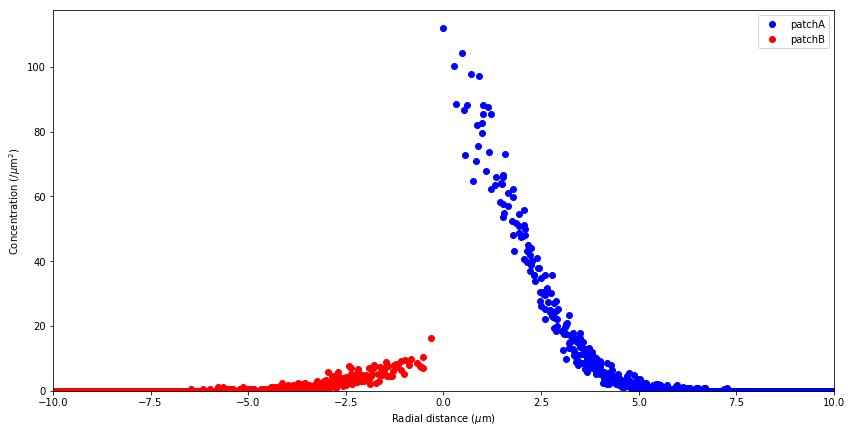

In [16]:
pylab.figure(figsize=(14,7))
plotres(20)

This plot shows a surface diffusion where the low rate of diffusion from patchA towards patchB can clearly
be seen by the lower concentration in patchB.